In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# from sklearn.feature_selection import r_regression
# from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
# load utilities

%run ./utility/utilities.py

/Users/4476224/.local/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.12.2
ipykernel        : 6.29.5
ipywidgets       : 8.1.3
jupyter_client   : 8.6.2
jupyter_core     : 5.7.2
jupyter_server   : 2.7.0
jupyterlab       : 4.2.3
nbclient         : 0.10.0
nbconvert        : 7.16.4
nbformat         : 5.10.4
notebook         : 7.2.1
qtconsole        : 5.5.2
traitlets        : 5.14.3


## Training and Testing dataset (7 robust predictive features) 

In [5]:
# (B001 - B131) 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

# load data
data = pd.read_excel('data/BladderCancer_132P_TIL_prd1.xlsx')
data = data.loc[0:130]

Ndata = data[['ID','Surgeon','Age_at_Surgery','Race','Surgery','Smoker','BMI',\
              'NAC','cT','pT','cT_or_pT','pN','Bx_Histology','Histology',\
              'Sample_weight_g_tumor','Tumor_digest_count_primary_tumor','Number_of_fragments_plated_tumor',\
              'Overall_TIL_growth']].copy()

Ndata = Ndata.replace(to_replace="Yes",value="Yes TIL")
Ndata = Ndata.replace(to_replace="No",value="No TIL")

Ndata = Ndata.replace(r'^\s*$', np.nan, regex=True) # Replace Blank values with DataFrame.replace() methods.

Extracted_col0 = Ndata.iloc[:,0:1]  # "ID"
Extracted_col1 = Ndata['Surgeon']
Extracted_col2 = Ndata['Age_at_Surgery']
Extracted_col3 = Ndata['BMI']
Extracted_col4 = Ndata['cT_or_pT']
Extracted_col5 = Ndata['Histology'] # may remove
Extracted_col6 = Ndata['Sample_weight_g_tumor']
Extracted_col7 = Ndata['Tumor_digest_count_primary_tumor']
Extracted_col8 = Ndata['Number_of_fragments_plated_tumor']
Extracted_col9 = Ndata['Overall_TIL_growth']

ndata_sel = Extracted_col0
ndata_sel = ndata_sel.join(Extracted_col1)
ndata_sel = ndata_sel.join(Extracted_col2)
ndata_sel = ndata_sel.join(Extracted_col3)
ndata_sel = ndata_sel.join(Extracted_col4)
ndata_sel = ndata_sel.join(Extracted_col5) # may remove
ndata_sel = ndata_sel.join(Extracted_col6)
ndata_sel = ndata_sel.join(Extracted_col7)
ndata_sel = ndata_sel.join(Extracted_col8)
ndata_sel = ndata_sel.join(Extracted_col9)

ndata_sel = ndata_sel.rename(columns={'Overall_TIL_growth': 'OverallTILGrowth'})

Cols = ['Surgeon','Age at Surgery','BMI',\
        'cT or pT',\
        'Sample weight (g) tumor','Tumor digest count (primary tumor)','Number of fragments plated (tumor)',\
        'OverallTILGrowth']

feats = ['Surgeon','Age at Surgery','Race','Surgery','Smoker','BMI',\
        'NAC','cT','pT','cT or pT','pN','Bx Histology','Histology',\
        'Sample weight (g) tumor','Tumor digest count (primary tumor)','Number of fragments plated (tumor)']

feat_labels = feats

In [6]:
# Filter all rows for which has NaN (7 Robust & Predictive Features)

ndata_sel.dropna(inplace=True) # drop rows with Nan, no entries
# ndata_filt = ndata_sel[ndata_sel['OverallTILGrowth'].notna()]


ndata_filt = ndata_sel
print(ndata_filt.shape)

(99, 10)


In [7]:
ndata_filt = ndata_filt.replace(to_replace='Yes TIL',value='1')
ndata_filt = ndata_filt.replace(to_replace='No TIL',value='-1')

# convert column "OverallTILGrowth" of Ndata to numerics
ndata_filt["OverallTILGrowth"] = pd.to_numeric(ndata_filt["OverallTILGrowth"])

ndata_filt.head()

,ID,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Histology,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor,OverallTILGrowth
0,B001,4.0,68.0,21.05,4.0,1.0,1.66,60000000.0,24.0,-1
1,B002,4.0,57.0,33.76,4.0,10.0,0.46,5000000.0,12.0,1
2,B003,1.0,61.0,26.28,7.0,7.0,1.17,3500000.0,12.0,1
3,B004,1.0,91.0,19.22,4.0,1.0,0.71,1300000.0,12.0,1
7,B008,2.0,79.0,26.71,4.0,4.0,0.04,300000.0,5.0,1


In [8]:
print(ndata_filt.shape)

(99, 10)


## remove the Ext validation data from the dataset

In [9]:
n_X_ExtVal_ID = ['B035', 'B023', 'B089', 'B102', 'B091', 'B093', 'B002', 'B008', 'B004', 'B015', 'B020', 'B014', 'B099', 'B083', 'B012', 'B028', 'B021', 'B052', 'B054', 'B027']

# 
n_X_ExtVal = ndata_filt[ndata_filt['ID'].isin(n_X_ExtVal_ID)]

In [11]:
n_X_ExtVal

,ID,Surgeon,Age_at_Surgery,BMI,cT_or_pT,Histology,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,Number_of_fragments_plated_tumor,OverallTILGrowth
1,B002,4.0,57.0,33.76,4.0,10.0,0.46,5000000.0,12.0,1
3,B004,1.0,91.0,19.22,4.0,1.0,0.71,1300000.0,12.0,1
7,B008,2.0,79.0,26.71,4.0,4.0,0.04,300000.0,5.0,1
11,B012,2.0,78.0,26.33,1.0,4.0,0.17,600000.0,5.0,-1
13,B014,4.0,69.0,34.21,4.0,1.0,1.30,2800000.0,6.0,1
14,B015,4.0,63.0,34.73,4.0,0.0,1.34,1000000.0,10.0,-1
19,B020,4.0,57.0,31.86,1.0,1.0,2.40,255000000.0,24.0,1
20,B021,4.0,58.0,25.96,4.0,6.0,0.60,2500000.0,12.0,-1
22,B023,4.0,62.0,24.91,4.0,10.0,0.18,1170000.0,6.0,-1
26,B027,4.0,73.0,26.61,10.0,1.0,3.03,26000000.0,24.0,1


In [12]:
y_ExtVal = n_X_ExtVal.iloc[:, -1] #.values

In [13]:
def remove_ExtVal_from_df(df1,df2):
    values_to_remove = list(df1['ID'].values)
    n_set = len(values_to_remove)
    
    for i in range(n_set):
        tmp = df2[df2['ID'] == values_to_remove[i]].index
        df2.drop(tmp,inplace=True)

    return df2

In [14]:
# data for training 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

# load data
data = pd.read_csv('data/Xy_16f_86p_midas.csv')

Ndata2 = data[['Age_at_Surgery','BMI','Histology','Number_of_fragments_plated_tumor',\
              'Sample_weight_g_tumor','Tumor_digest_count_primary_tumor','OverallTILGrowth']].copy()
              
              


In [15]:
ndata_filt = Ndata2
print(ndata_filt.shape)

(86, 7)


In [16]:
ndata_filt.dropna(subset=['OverallTILGrowth'],inplace=True) # drop rows with Nan, no entries
print(ndata_filt.shape)

(86, 7)


In [17]:
ndata_filt = ndata_filt.replace(to_replace='Yes TIL',value='1')
ndata_filt = ndata_filt.replace(to_replace='No TIL',value='-1')

# convert column "OverallTILGrowth" of Ndata to numerics
ndata_filt["OverallTILGrowth"] = pd.to_numeric(ndata_filt["OverallTILGrowth"])

ndata_filt.head()

,Age_at_Surgery,BMI,Histology,Number_of_fragments_plated_tumor,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor,OverallTILGrowth
0,68.0,21.05,1.0,24.0,1.66,60000000.0,-1
1,61.0,26.28,7.0,12.0,1.17,3500000.0,1
2,71.0,20.19,1.0,12.0,0.00,210000.0,-1
3,73.0,33.95,1.0,10.0,0.00,2000000.0,-1
4,68.0,21.32,2.0,6.0,0.34,465000.0,1


In [18]:
print(ndata_filt.shape)

(86, 7)


In [19]:
# 

Xy_filt = ndata_filt

# Xy_filt = Xy_filt.drop('ID', axis=1)
Xy_filt = Xy_filt.apply(pd.to_numeric) # convert all columns of Ndata to numerics

X = Xy_filt.iloc[:,:-1]
y = Xy_filt.iloc[:, -1] #.values

X.head()

,Age_at_Surgery,BMI,Histology,Number_of_fragments_plated_tumor,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor
0,68.0,21.05,1.0,24.0,1.66,60000000.0
1,61.0,26.28,7.0,12.0,1.17,3500000.0
2,71.0,20.19,1.0,12.0,0.00,210000.0
3,73.0,33.95,1.0,10.0,0.00,2000000.0
4,68.0,21.32,2.0,6.0,0.34,465000.0


In [20]:
# # 

# Xy_filt = remove_ExtVal_from_df(n_X_ExtVal,ndata_filt)

# print(Xy_filt.shape)

In [21]:
# # 

# Xy_filt = Xy_filt.drop('ID', axis=1)
# Xy_filt = Xy_filt.apply(pd.to_numeric) # convert all columns of Ndata to numerics

# X = Xy_filt.iloc[:,:-1]
# y = Xy_filt.iloc[:, -1] #.values

# X.head()

In [22]:
print(X.shape)

(86, 6)


In [23]:
print(y.shape)

(86,)


In [24]:
# data (B001 - B131)

X_train, X_test, y_train, y_test = data_split(X,y,rnd_st=1234,tst_sz=0.30)        # working best for now


In [25]:
X_train.head()

,Age_at_Surgery,BMI,Histology,Number_of_fragments_plated_tumor,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor
27,75.0,28.35,1.0,12.0,0.00,1000000.0
39,82.0,34.83,1.0,24.0,8.56,10100000.0
2,71.0,20.19,1.0,12.0,0.00,210000.0
71,77.0,25.56,1.0,0.0,0.00,0.0
28,70.0,36.62,4.0,24.0,2.79,100000000.0


In [26]:
X_test.head()

,Age_at_Surgery,BMI,Histology,Number_of_fragments_plated_tumor,Sample_weight_g_tumor,Tumor_digest_count_primary_tumor
8,60.0,24.10,4.0,24.0,0.00,3500000.0
62,45.0,22.11,1.0,18.0,1.31,7160000.0
55,60.0,4.89,1.0,0.0,0.00,0.0
29,69.0,25.99,1.0,6.0,0.00,2000000.0
73,79.0,28.86,1.0,2.0,0.05,217000.0


In [27]:
scaler = StandardScaler().fit(X_train) # build a scaler for the training data


In [28]:
# scaled x_train

X_train_sc = scaler.transform(X_train) # use the scaler to transform the training data

In [29]:
# scaled x_test

X_test_sc = scaler.transform(X_test) # use the scaler to transform the testing data


## Testing on the Ext Validation set

In [30]:

# n_X_ExtVal_r = n_X_ExtVal[['Surgeon','Age_at_Surgery','BMI','cT_or_pT','Sample_weight_g_tumor',\
#                           'Tumor_digest_count_primary_tumor','Number_of_fragments_plated_tumor']].copy()

n_X_ExtVal_r = n_X_ExtVal[['Age_at_Surgery','BMI','Histology','Number_of_fragments_plated_tumor',\
                           'Sample_weight_g_tumor','Tumor_digest_count_primary_tumor']].copy()


n_X_ExtVal_r = n_X_ExtVal_r.apply(pd.to_numeric) # convert all columns of Ndata to numerics

# scaled x_ExtVal
X_extVal_sc = scaler.transform(n_X_ExtVal_r)

In [31]:
# read in the best hyperparams

with open("best_hyperparams_cv_2_10_IM.txt", "r") as file:
    lines = file.read().splitlines()  # Reads without newline characters

# Assign each line to a variable
best_hyperparams_cv2, best_hyperparams_cv3, best_hyperparams_cv4, best_hyperparams_cv5, best_hyperparams_cv6, best_hyperparams_cv7, best_hyperparams_cv8, best_hyperparams_cv9, best_hyperparams_cv10 = lines[:9]  

thresh: 0.5000, mcc: 0.0000, AUC test-set: 0.5531
[[16  0]
 [10  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        10
           1       0.62      1.00      0.76        16

    accuracy                           0.62        26
   macro avg       0.31      0.50      0.38        26
weighted avg       0.38      0.62      0.47        26

thresh: 0.5000, mcc: 0.0000, AUC test-set: 0.5156
[[16  0]
 [ 4  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.80      1.00      0.89        16

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20

thresh: 0.5860, mcc: -0.1231, AUC test-set: 0.5531
[[ 6 10]
 [ 5  5]]
              precision    recall  f1-score   support

          -1       0.33      0.50      0.40        10
           1       0.55      

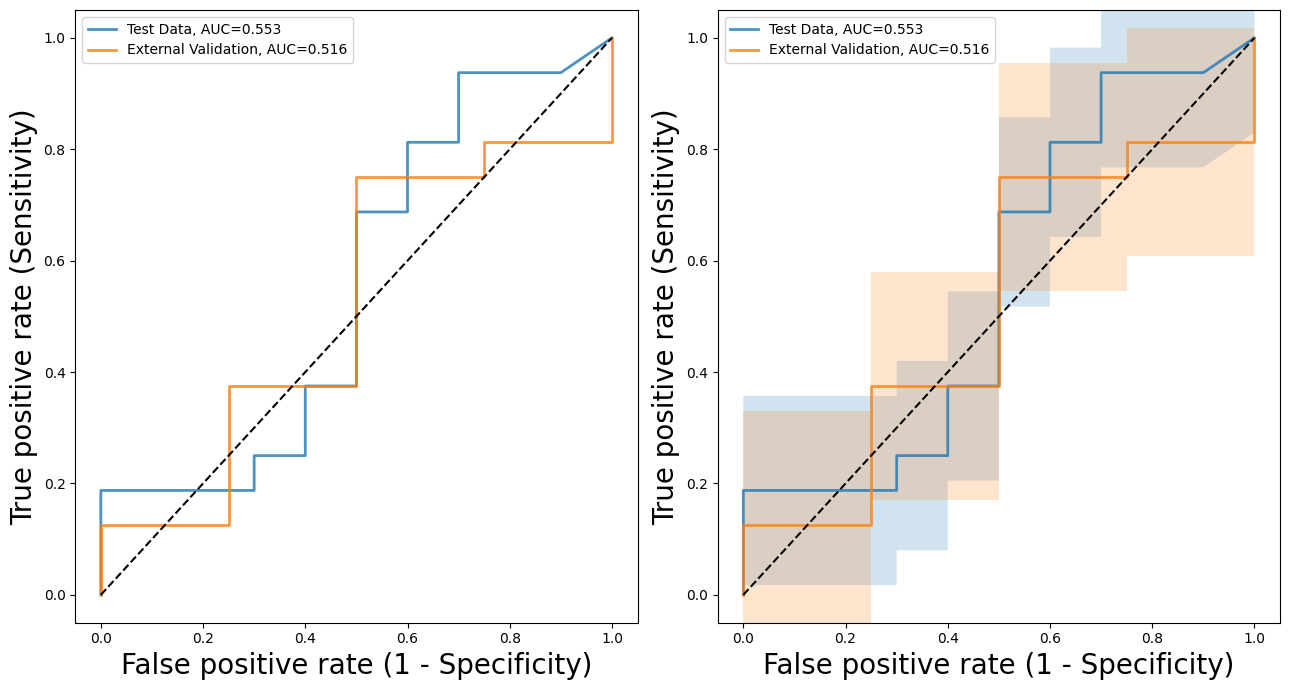

In [32]:
# cv = 2, kl = rbf

# y_pred,y_test,test_probs,val_probs,cm_test_50,cm_test_Opt,cm_val_Opt

# convert values to float
values2 = best_hyperparams_cv2.split(", "); C2 = float(values2[0]); gamma2 = float(values2[1])

# 'MCC'
mcc_Opt_2,thr_Opt_2,y_pred_2,y_test_2,test_probs_2,val_probs_2,cm_50_2,cm_Opt_2,cm_50Val_2,cm_OptVal_2 = model_svm_predict(X_train_sc,y_train,
                                                                    X_test_sc,y_test,
                                                                    X_extVal_sc,y_ExtVal,
                                                                    C2, gamma2,2,
                                                                    K_R_M = 'MCC',kl ="rbf")
print("mcc on training = " + str(mcc_Opt_2))
print("threshold on training = " + str(thr_Opt_2))

# # 'Kappa'
# thr_Opt_2,y_pred_2,y_test_2,test_probs_2,val_probs_2,cm_50_2,cm_Opt_2,cm_50Val_2,cm_OptVal_2 = model_svm_predict(X_train_sc,y_train,
#                                                                     X_test_sc,y_test,
#                                                                     X_extVal_sc,y_ExtVal,
#                                                                     best_hyperparams_cv2,2,
#                                                                     K_R_M = 'Kappa',kl ="rbf")

# confidence intervals for accuracy,recall,precision,specificity
y_pred_opt_2 = []
threshold = thr_Opt_2

y_pred_opt_2 = [1 if x>=threshold else -1 for x in test_probs_2]

savefig('./figs/aucroc_cv2_IM')

<Figure size 1500x1000 with 0 Axes>

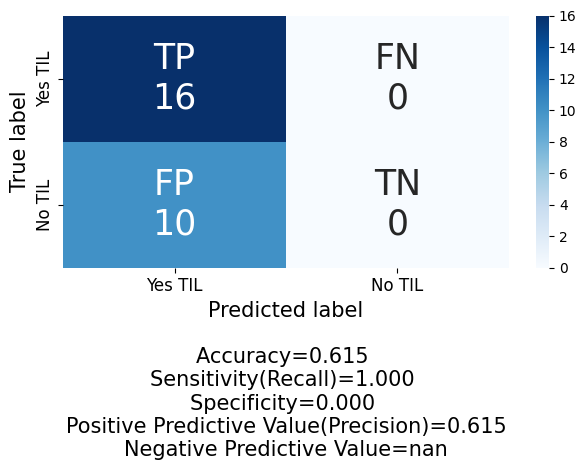

In [33]:
plt.figure(figsize=(15, 10))
my_cm(cm_50_2)

plt.tight_layout()
savefig('./figs/cm_50_2_IM')

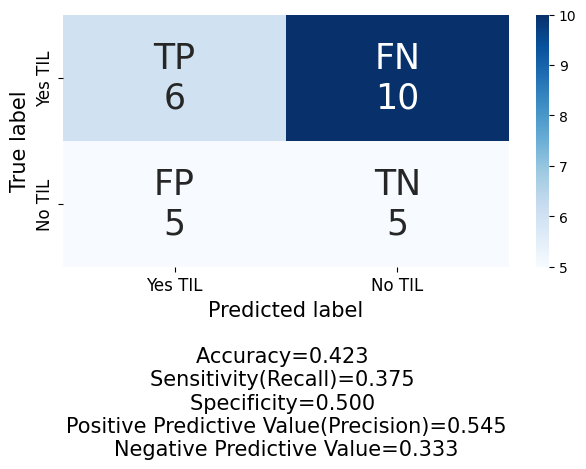

In [34]:
my_cm(cm_Opt_2)

savefig('./figs/cm_Opt_2_IM')

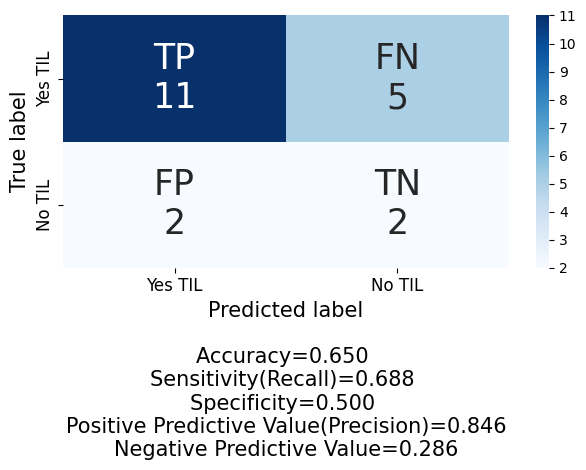

In [35]:
my_cm(cm_OptVal_2)

savefig('./figs/cm_OptVal_2_IM')

thresh: 0.5000, mcc: 0.1299, AUC test-set: 0.5813
[[13  3]
 [ 7  3]]
              precision    recall  f1-score   support

          -1       0.50      0.30      0.37        10
           1       0.65      0.81      0.72        16

    accuracy                           0.62        26
   macro avg       0.57      0.56      0.55        26
weighted avg       0.59      0.62      0.59        26

thresh: 0.5000, mcc: -0.1667, AUC test-set: 0.4531
[[14  2]
 [ 4  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.78      0.88      0.82        16

    accuracy                           0.70        20
   macro avg       0.39      0.44      0.41        20
weighted avg       0.62      0.70      0.66        20

thresh: 0.5930, mcc: -0.0610, AUC test-set: 0.5813
[[7 9]
 [5 5]]
              precision    recall  f1-score   support

          -1       0.36      0.50      0.42        10
           1       0.58      0.4

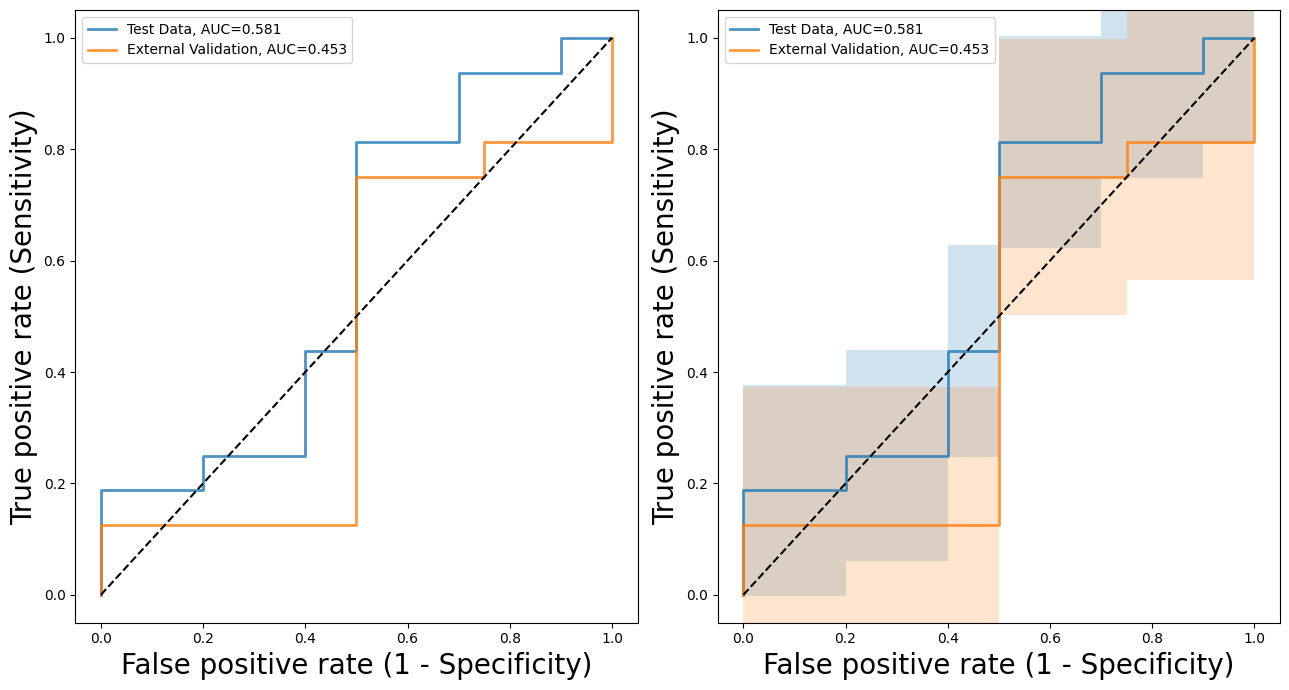

In [36]:
# cv = 3, kl = rbf

# convert values to float
values3 = best_hyperparams_cv3.split(", "); C3 = float(values3[0]); gamma3 = float(values3[1])

# 'MCC'
mcc_Opt_3,thr_Opt_3,y_pred_3,y_test_3,test_probs_3,val_probs_3,cm_50_3,cm_Opt_3,cm_50Val_3,cm_OptVal_3 = model_svm_predict(X_train_sc,y_train,
                                                                    X_test_sc,y_test,
                                                                    X_extVal_sc,y_ExtVal,
                                                                    C3, gamma3,3,
                                                                    K_R_M = 'MCC',kl ="rbf")
print("mcc on training = " + str(mcc_Opt_3))
print("threshold on training = " + str(thr_Opt_3))

# # 'Kappa'
# thr_Opt_3,y_pred_3,y_test_3,test_probs_3,val_probs_3,cm_50_3,cm_Opt_3,cm_50Val_3,cm_OptVal_3 = model_svm_predict(X_train_sc,y_train,
#                                                                     X_test_sc,y_test,
#                                                                     X_extVal_sc,y_ExtVal,
#                                                                     best_hyperparams_cv3,3,
#                                                                     K_R_M = 'Kappa',kl ="rbf")

# confidence intervals for accuracy,recall,precision,specificity
y_pred_opt_3 = []
threshold = thr_Opt_3

y_pred_opt_3 = [1 if x>=threshold else -1 for x in test_probs_3]

savefig('./figs/aucroc_cv3_IM')

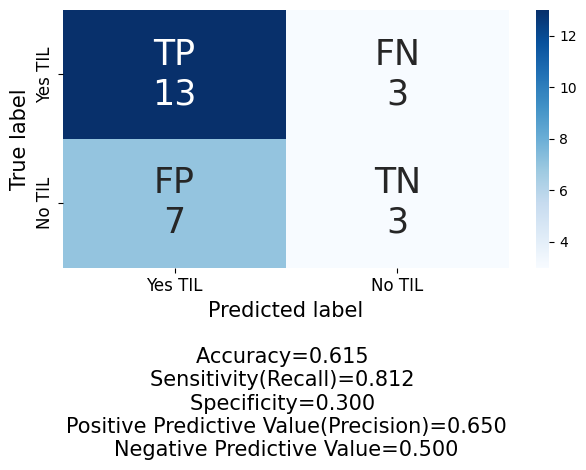

In [37]:
my_cm(cm_50_3)

savefig('./figs/cm_50_3_IM')

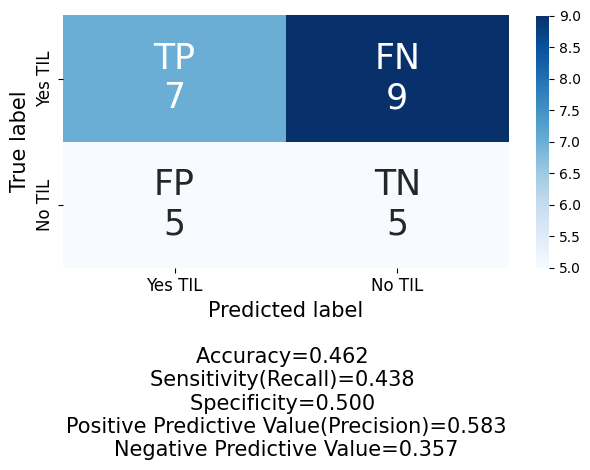

In [38]:
my_cm(cm_Opt_3)

savefig('./figs/cm_Opt_3_IM')

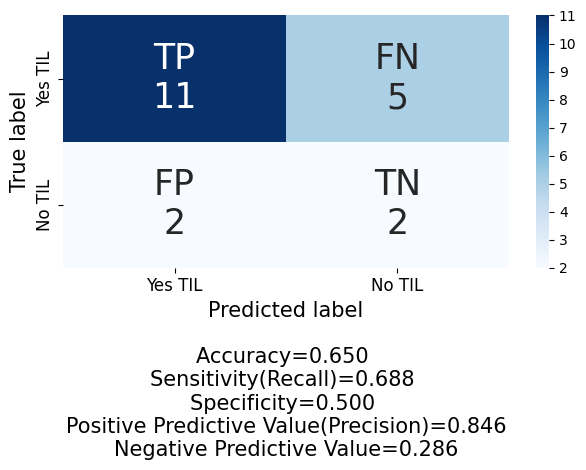

In [39]:
my_cm(cm_OptVal_3)

savefig('./figs/cm_OptVal_3_IM')

thresh: 0.5000, mcc: 0.1299, AUC test-set: 0.5562
[[13  3]
 [ 7  3]]
              precision    recall  f1-score   support

          -1       0.50      0.30      0.37        10
           1       0.65      0.81      0.72        16

    accuracy                           0.62        26
   macro avg       0.57      0.56      0.55        26
weighted avg       0.59      0.62      0.59        26

thresh: 0.5000, mcc: -0.1667, AUC test-set: 0.5156
[[14  2]
 [ 4  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.78      0.88      0.82        16

    accuracy                           0.70        20
   macro avg       0.39      0.44      0.41        20
weighted avg       0.62      0.70      0.66        20

thresh: 0.6000, mcc: -0.1231, AUC test-set: 0.5562
[[ 6 10]
 [ 5  5]]
              precision    recall  f1-score   support

          -1       0.33      0.50      0.40        10
           1       0.55     

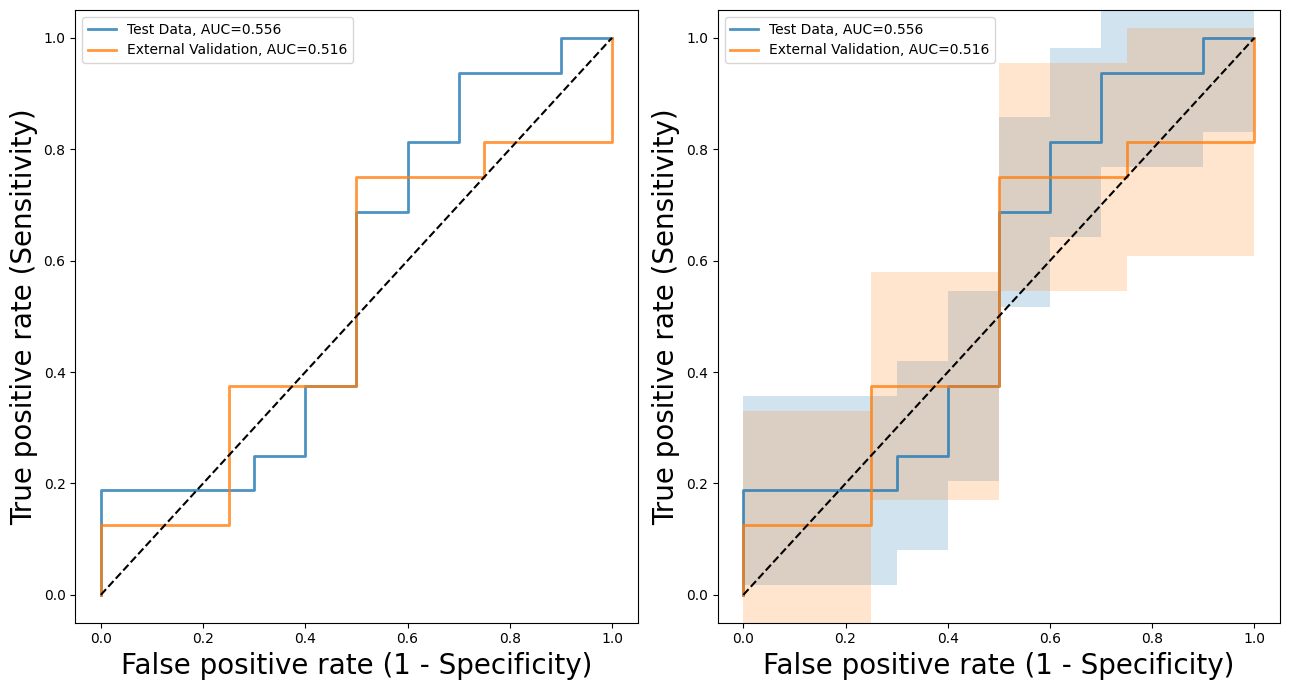

In [40]:
# cv = 4, kl = rbf

# convert values to float
values4 = best_hyperparams_cv4.split(", "); C4 = float(values4[0]); gamma4 = float(values4[1])

# 'MCC'
mcc_Opt_4,thr_Opt_4,y_pred_4,y_test_4,test_probs_4,val_probs_4,cm_50_4,cm_Opt_4,cm_50Val_4,cm_OptVal_4 = model_svm_predict(X_train_sc,y_train,
                                                                    X_test_sc,y_test,
                                                                    X_extVal_sc,y_ExtVal,
                                                                    C4, gamma4,4,
                                                                    K_R_M = 'MCC',kl ="rbf")
print("mcc on training = " + str(mcc_Opt_4))
print("threshold on training = " + str(thr_Opt_4))

# # 'Kappa'
# thr_Opt_4,y_pred_4,y_test_4,test_probs_4,val_probs_4,cm_50_4,cm_Opt_4,cm_50Val_4,cm_OptVal_4 = model_svm_predict(X_train_sc,y_train,
#                                                                     X_test_sc,y_test,
#                                                                     X_extVal_sc,y_ExtVal,
#                                                                     best_hyperparams_cv4,4,
#                                                                     K_R_M = 'Kappa',kl ="rbf")

# confidence intervals for accuracy,recall,precision,specificity
y_pred_opt_4 = []
threshold = thr_Opt_4

y_pred_opt_4 = [1 if x>=threshold else -1 for x in test_probs_4]

savefig('./figs/aucroc_cv4_IM')

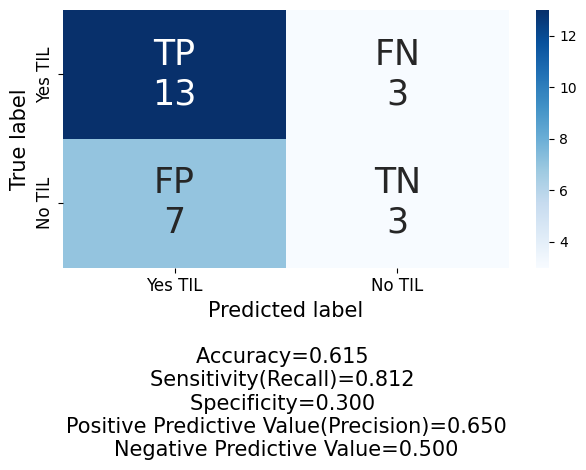

In [41]:
my_cm(cm_50_4)

savefig('./figs/cm_50_4_IM')

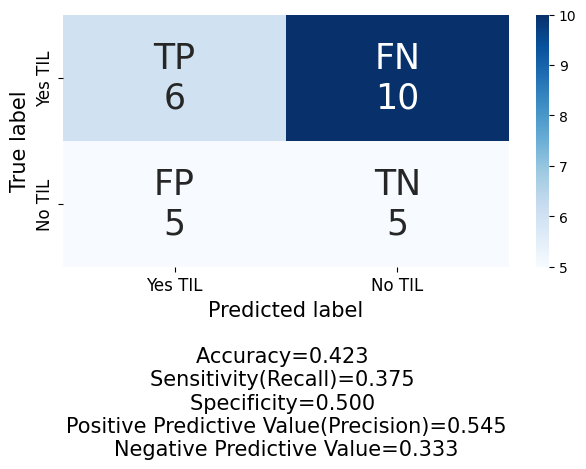

In [42]:
my_cm(cm_Opt_4)

savefig('./figs/cm_Opt_4_IM')

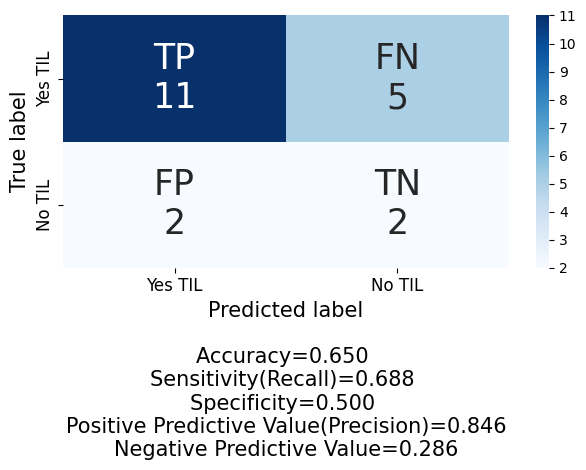

In [43]:
my_cm(cm_OptVal_4)

savefig('./figs/cm_OptVal_4_IM')

thresh: 0.5000, mcc: 0.2160, AUC test-set: 0.6375
[[14  2]
 [ 7  3]]
              precision    recall  f1-score   support

          -1       0.60      0.30      0.40        10
           1       0.67      0.88      0.76        16

    accuracy                           0.65        26
   macro avg       0.63      0.59      0.58        26
weighted avg       0.64      0.65      0.62        26

thresh: 0.5000, mcc: -0.1147, AUC test-set: 0.6094
[[15  1]
 [ 4  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.79      0.94      0.86        16

    accuracy                           0.75        20
   macro avg       0.39      0.47      0.43        20
weighted avg       0.63      0.75      0.69        20

thresh: 0.5330, mcc: 0.2331, AUC test-set: 0.6375
[[13  3]
 [ 6  4]]
              precision    recall  f1-score   support

          -1       0.57      0.40      0.47        10
           1       0.68      

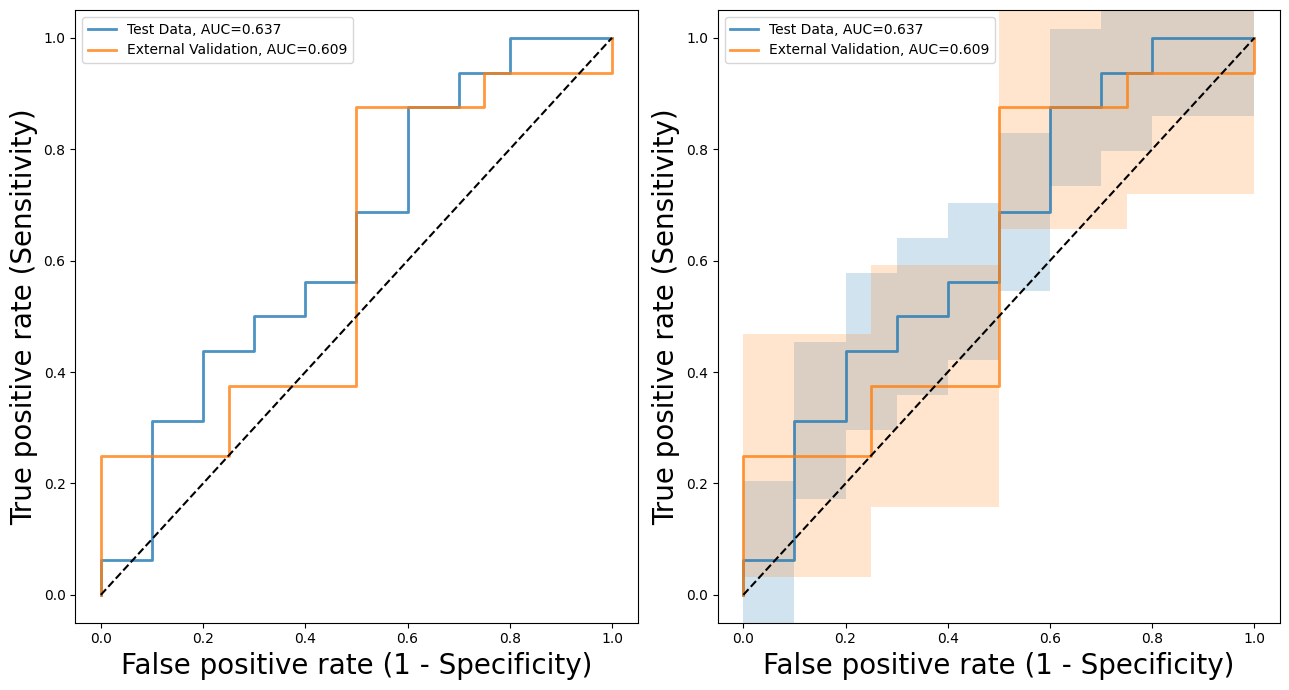

In [44]:
# cv = 5, kl = rbf

# convert values to float
values5 = best_hyperparams_cv5.split(", "); C5 = float(values5[0]); gamma5 = float(values5[1])

# 'MCC'
mcc_Opt_5,thr_Opt_5,y_pred_5,y_test_5,test_probs_5,val_probs_5,cm_50_5,cm_Opt_5,cm_50Val_5,cm_OptVal_5 = model_svm_predict(X_train_sc,y_train,
                                                                    X_test_sc,y_test,
                                                                    X_extVal_sc,y_ExtVal,
                                                                    C5, gamma5,5,
                                                                    K_R_M = 'MCC',kl ="rbf")
print("mcc on training = " + str(mcc_Opt_5))
print("threshold on training = " + str(thr_Opt_5))

# # 'Kappa'
# thr_Opt_5,y_pred_5,y_test_5,test_probs_5,val_probs_5,cm_50_5,cm_Opt_5,cm_50Val_5,cm_OptVal_5 = model_svm_predict(X_train_sc,y_train,
#                                                                     X_test_sc,y_test,
#                                                                     X_extVal_sc,y_ExtVal,
#                                                                     best_hyperparams_cv5,5,
#                                                                     K_R_M = 'Kappa',kl ="rbf")

# confidence intervals for accuracy,recall,precision,specificity
y_pred_opt_5 = []
threshold = thr_Opt_5

y_pred_opt_5 = [1 if x>=threshold else -1 for x in test_probs_5]

savefig('./figs/aucroc_cv5_IM')

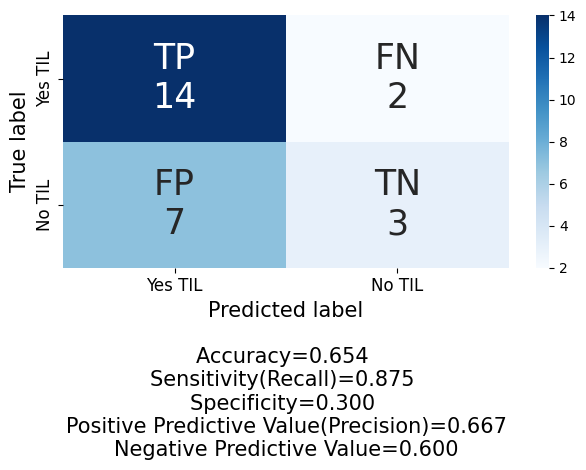

In [45]:
my_cm(cm_50_5)

savefig('./figs/cm_50_5_IM')

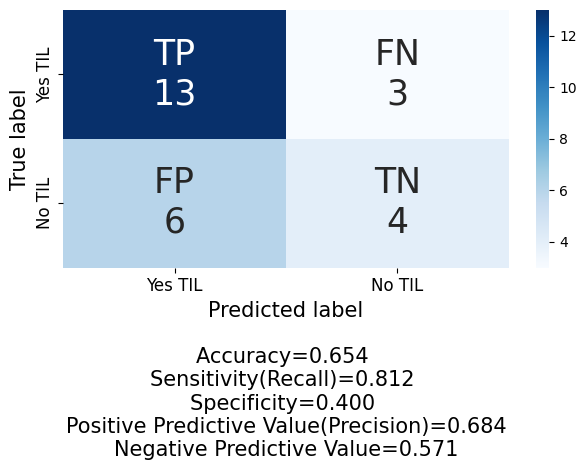

In [46]:
my_cm(cm_Opt_5)

savefig('./figs/cm_Opt_5_IM')

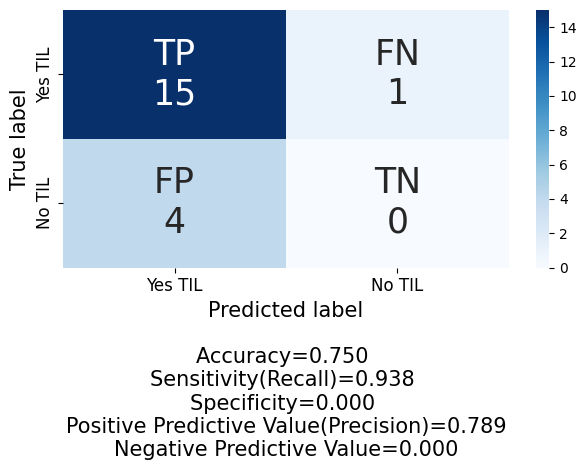

In [47]:
my_cm(cm_OptVal_5)

savefig('./figs/cm_OptVal_5_IM')

thresh: 0.5000, mcc: 0.2331, AUC test-set: 0.5938
[[13  3]
 [ 6  4]]
              precision    recall  f1-score   support

          -1       0.57      0.40      0.47        10
           1       0.68      0.81      0.74        16

    accuracy                           0.65        26
   macro avg       0.63      0.61      0.61        26
weighted avg       0.64      0.65      0.64        26

thresh: 0.5000, mcc: -0.1147, AUC test-set: 0.5781
[[15  1]
 [ 4  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.79      0.94      0.86        16

    accuracy                           0.75        20
   macro avg       0.39      0.47      0.43        20
weighted avg       0.63      0.75      0.69        20

thresh: 0.6550, mcc: 0.0767, AUC test-set: 0.5938
[[ 6 10]
 [ 3  7]]
              precision    recall  f1-score   support

          -1       0.41      0.70      0.52        10
           1       0.67      

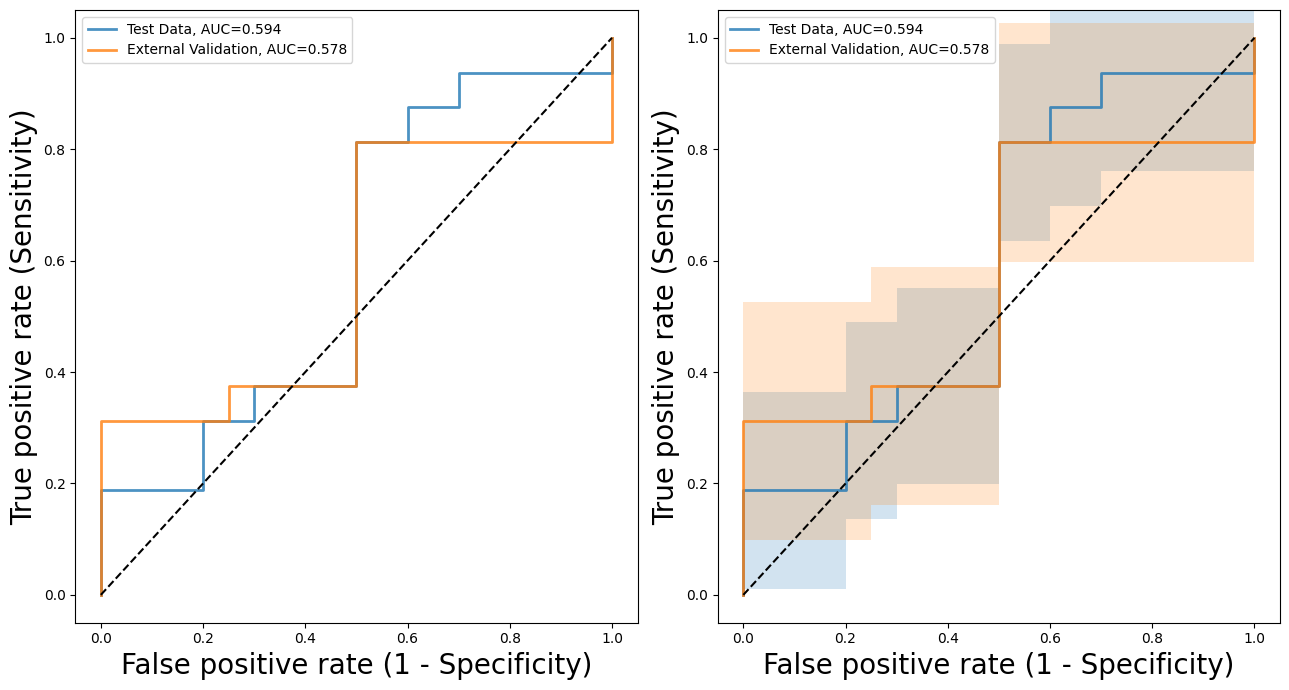

In [48]:
# cv = 6, kl = rbf

# convert values to float
values6 = best_hyperparams_cv6.split(", "); C6 = float(values6[0]); gamma6 = float(values6[1])

# 'MCC'
mcc_Opt_6,thr_Opt_6,y_pred_6,y_test_6,test_probs_6,val_probs_6,cm_50_6,cm_Opt_6,cm_50Val_6,cm_OptVal_6 = model_svm_predict(X_train_sc,y_train,
                                                                    X_test_sc,y_test,
                                                                    X_extVal_sc,y_ExtVal,
                                                                    C6, gamma6,6,
                                                                    K_R_M = 'MCC',kl ="rbf")
print("mcc on training = " + str(mcc_Opt_6))
print("threshold on training = " + str(thr_Opt_6))

# # 'Kappa'
# thr_Opt_6,y_pred_6,y_test_6,test_probs_6,val_probs_6,cm_50_6,cm_Opt_6,cm_50Val_6,cm_OptVal_6 = model_svm_predict(X_train_sc,y_train,
#                                                                     X_test_sc,y_test,
#                                                                     X_extVal_sc,y_ExtVal,
#                                                                     best_hyperparams_cv6,6,
#                                                                     K_R_M = 'Kappa',kl ="rbf")

# confidence intervals for accuracy,recall,precision,specificity
y_pred_opt_6 = []
threshold = thr_Opt_6

y_pred_opt_6 = [1 if x>=threshold else -1 for x in test_probs_6]

savefig('./figs/aucroc_cv6_IM')

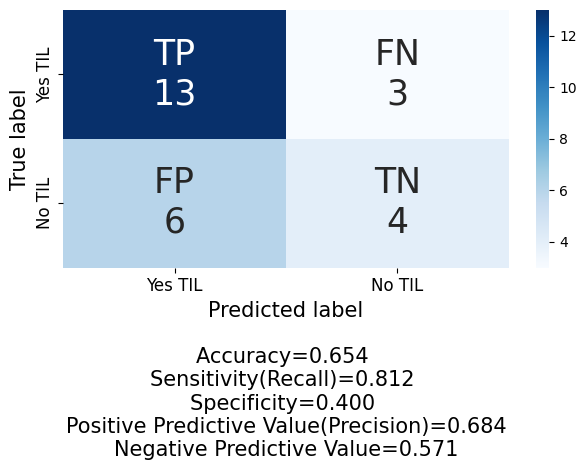

In [49]:
my_cm(cm_50_6)

savefig('./figs/cm_50_6_IM')

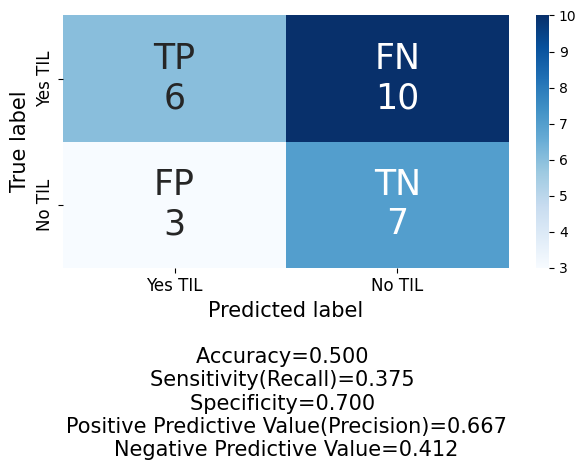

In [50]:
my_cm(cm_Opt_6)

savefig('./figs/cm_Opt_6_IM')

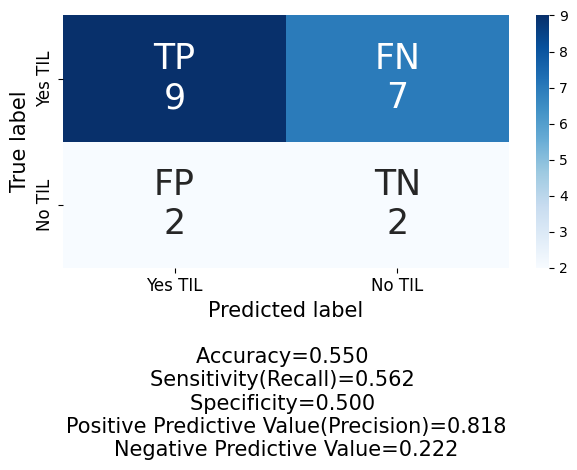

In [51]:
my_cm(cm_OptVal_6)

savefig('./figs/cm_OptVal_6_IM')

thresh: 0.5000, mcc: 0.2160, AUC test-set: 0.5687
[[14  2]
 [ 7  3]]
              precision    recall  f1-score   support

          -1       0.60      0.30      0.40        10
           1       0.67      0.88      0.76        16

    accuracy                           0.65        26
   macro avg       0.63      0.59      0.58        26
weighted avg       0.64      0.65      0.62        26

thresh: 0.5000, mcc: 0.0000, AUC test-set: 0.4844
[[16  0]
 [ 4  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.80      1.00      0.89        16

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20

thresh: 0.6530, mcc: 0.0577, AUC test-set: 0.5687
[[ 4 12]
 [ 2  8]]
              precision    recall  f1-score   support

          -1       0.40      0.80      0.53        10
           1       0.67      0

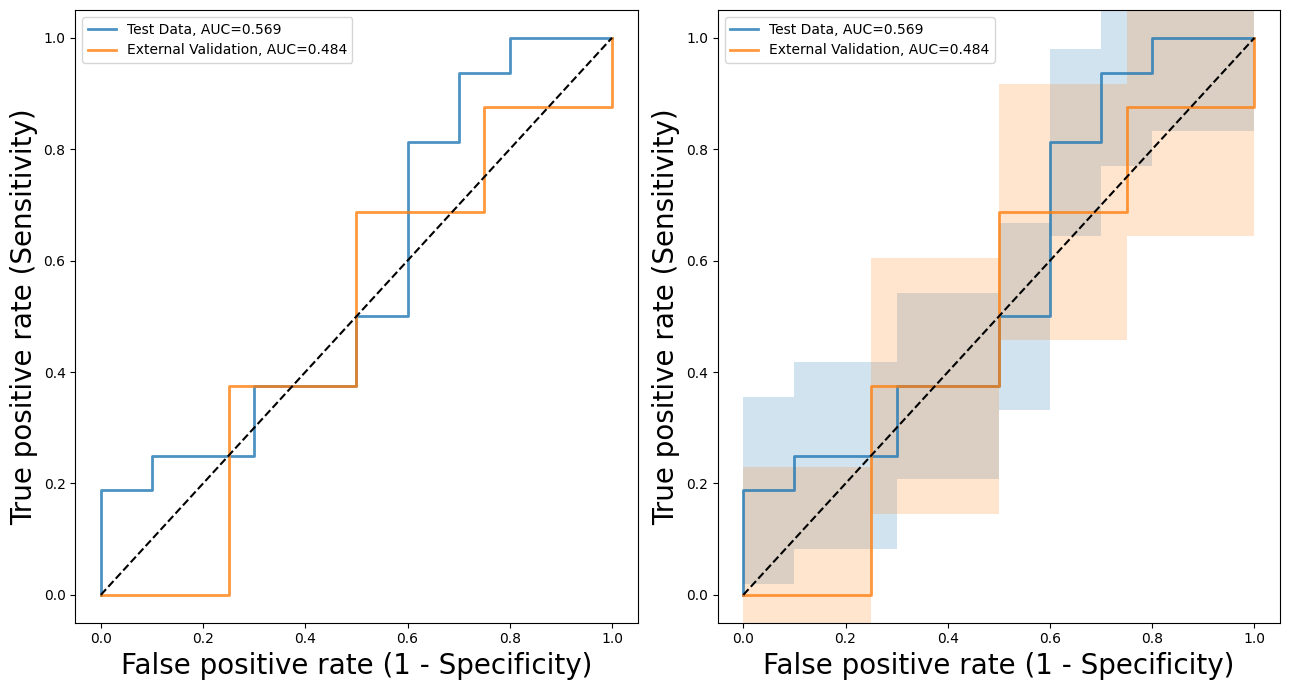

In [52]:
# cv = 7, kl = rbf

# convert values to float
values7 = best_hyperparams_cv7.split(", "); C7 = float(values7[0]); gamma7 = float(values7[1])

# 'MCC'
mcc_Opt_7,thr_Opt_7,y_pred_7,y_test_7,test_probs_7,val_probs_7,cm_50_7,cm_Opt_7,cm_50Val_7,cm_OptVal_7 = model_svm_predict(X_train_sc,y_train,
                                                                    X_test_sc,y_test,
                                                                    X_extVal_sc,y_ExtVal,
                                                                    C7, gamma7,7,
                                                                    K_R_M = 'MCC',kl ="rbf")
print("mcc on training = " + str(mcc_Opt_7))
print("threshold on training = " + str(thr_Opt_7))

# # 'Kappa'
# thr_Opt_7,y_pred_7,y_test_7,test_probs_7,val_probs_7,cm_50_7,cm_Opt_7,cm_50Val_7,cm_OptVal_7 = model_svm_predict(X_train_sc,y_train,
#                                                                     X_test_sc,y_test,
#                                                                     X_extVal_sc,y_ExtVal,
#                                                                     best_hyperparams_cv7,7,
#                                                                     K_R_M = 'Kappa',kl ="rbf")

# confidence intervals for accuracy,recall,precision,specificity
y_pred_opt_7 = []
threshold = thr_Opt_7

y_pred_opt_7 = [1 if x>=threshold else -1 for x in test_probs_7]

savefig('./figs/aucroc_cv7_IM')

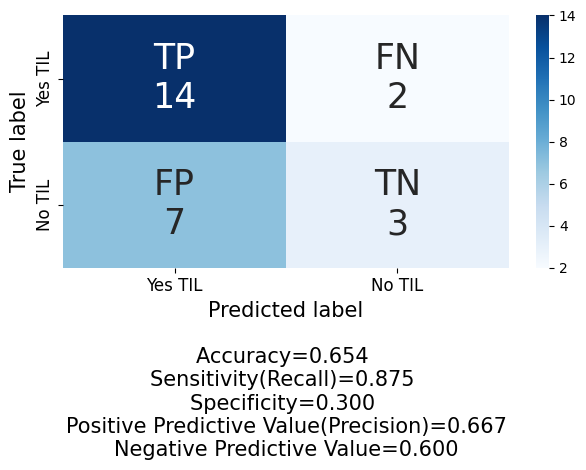

In [53]:
my_cm(cm_50_7)

savefig('./figs/cm_50_7_IM')

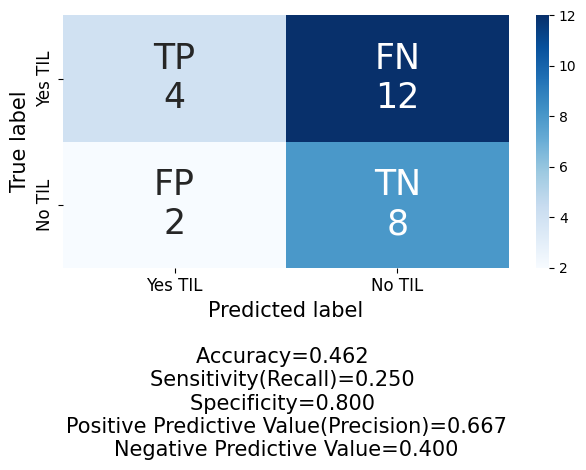

In [54]:
my_cm(cm_Opt_7)

savefig('./figs/cm_Opt_7_IM')

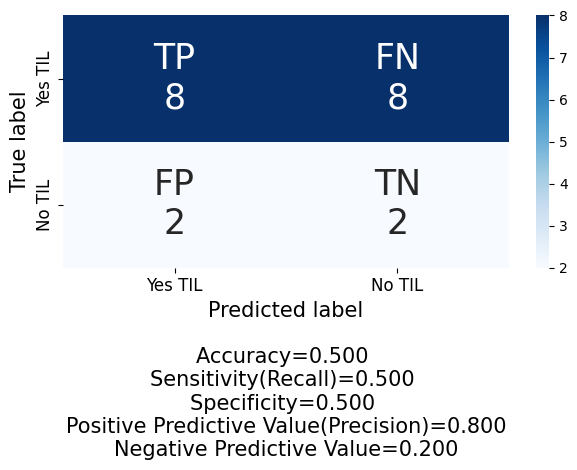

In [55]:
my_cm(cm_OptVal_7)

savefig('./figs/cm_OptVal_7_IM')

thresh: 0.5000, mcc: 0.1299, AUC test-set: 0.5500
[[13  3]
 [ 7  3]]
              precision    recall  f1-score   support

          -1       0.50      0.30      0.37        10
           1       0.65      0.81      0.72        16

    accuracy                           0.62        26
   macro avg       0.57      0.56      0.55        26
weighted avg       0.59      0.62      0.59        26

thresh: 0.5000, mcc: 0.0000, AUC test-set: 0.5000
[[16  0]
 [ 4  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.80      1.00      0.89        16

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20

thresh: 0.6960, mcc: 0.1180, AUC test-set: 0.5500
[[ 3 13]
 [ 1  9]]
              precision    recall  f1-score   support

          -1       0.41      0.90      0.56        10
           1       0.75      0

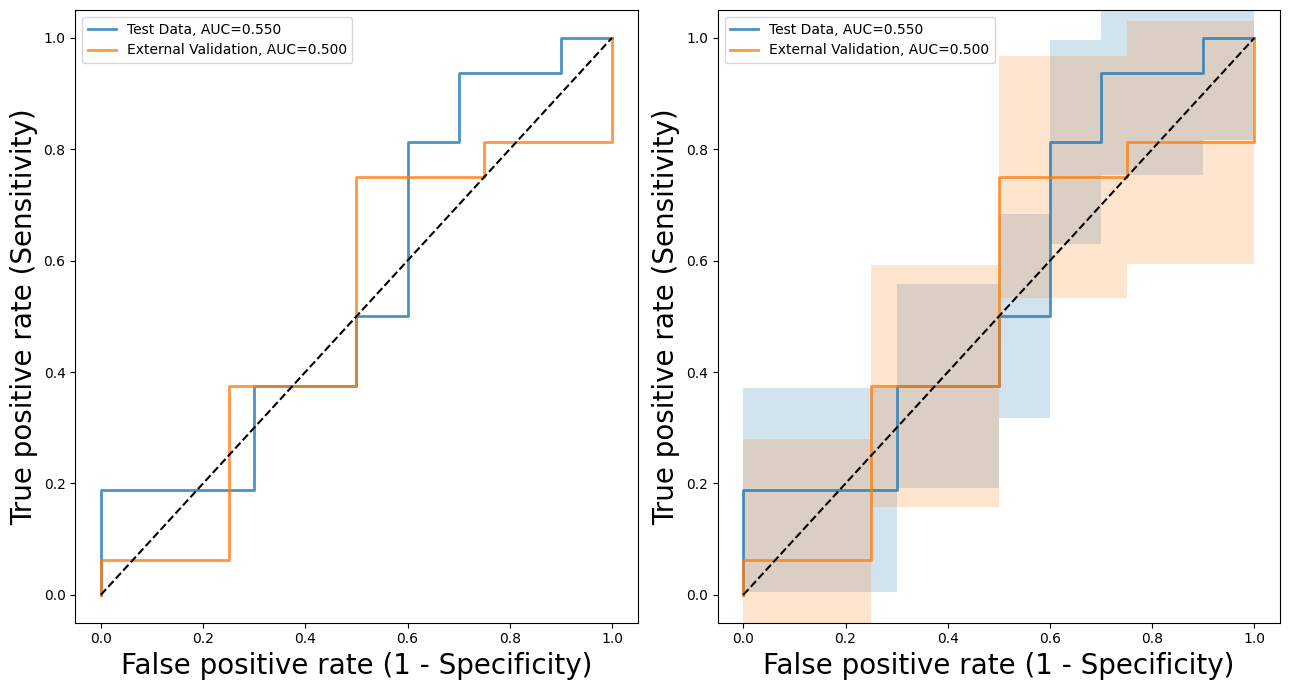

In [56]:
# cv = 8, kl = rbf

# convert values to float
values8 = best_hyperparams_cv8.split(", "); C8 = float(values8[0]); gamma8 = float(values8[1])

# 'MCC'
mcc_Opt_8,thr_Opt_8,y_pred_8,y_test_8,test_probs_8,val_probs_8,cm_50_8,cm_Opt_8,cm_50Val_8,cm_OptVal_8 = model_svm_predict(X_train_sc,y_train,
                                                                    X_test_sc,y_test,
                                                                    X_extVal_sc,y_ExtVal,
                                                                    C8, gamma8,8,
                                                                    K_R_M = 'MCC',kl ="rbf")
print("mcc on training = " + str(mcc_Opt_8))
print("threshold on training = " + str(thr_Opt_8))

# # 'Kappa'
# thr_Opt_8,y_pred_8,y_test_8,test_probs_8,val_probs_8,cm_50_8,cm_Opt_8,cm_50Val_8,cm_OptVal_8 = model_svm_predict(X_train_sc,y_train,
#                                                                     X_test_sc,y_test,
#                                                                     X_extVal_sc,y_ExtVal,
#                                                                     best_hyperparams_cv8,8,
#                                                                     K_R_M = 'Kappa',kl ="rbf")

# confidence intervals for accuracy,recall,precision,specificity (test data)
y_pred_opt_8 = []
threshold = thr_Opt_8

y_pred_opt_8 = [1 if x>=threshold else -1 for x in test_probs_8]

# confidence intervals for accuracy,recall,precision,specificity (ext data)
val_pred_opt_8 = []
threshold = thr_Opt_8

val_pred_opt_8 = [1 if x>=threshold else -1 for x in val_probs_8]

savefig('./figs/aucroc_cv8_IM')

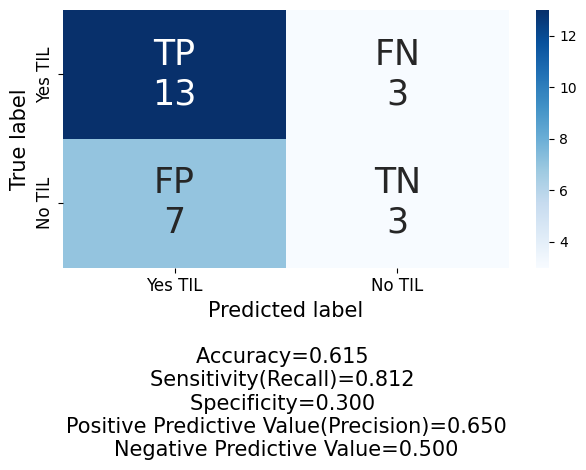

In [57]:
my_cm(cm_50_8)

savefig('./figs/cm_50_8_IM')

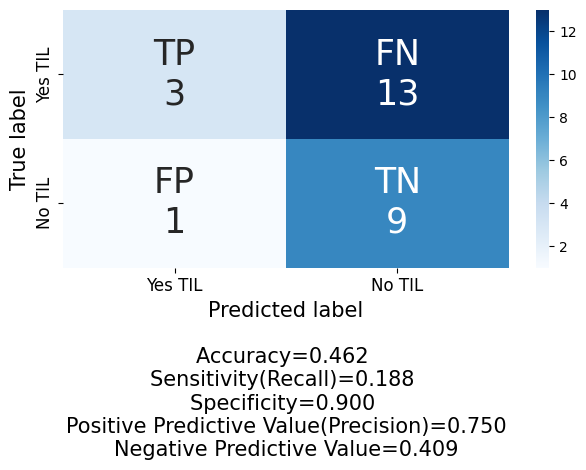

In [58]:
my_cm(cm_Opt_8)

savefig('./figs/cm_Opt_8_IM')

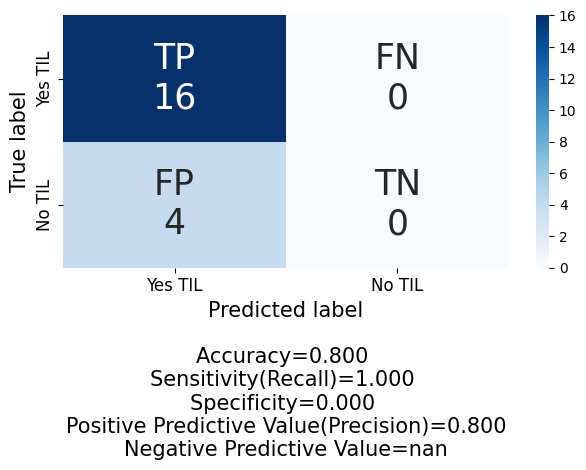

In [59]:
my_cm(cm_50Val_8)

savefig('./figs/cm_50Val_8_IM')

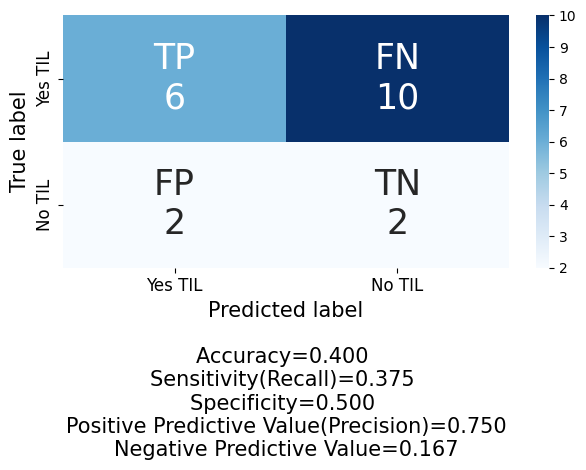

In [60]:
my_cm(cm_OptVal_8)

savefig('./figs/cm_OptVal_8_IM')

thresh: 0.5000, mcc: 0.0000, AUC test-set: 0.5500
[[16  0]
 [10  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        10
           1       0.62      1.00      0.76        16

    accuracy                           0.62        26
   macro avg       0.31      0.50      0.38        26
weighted avg       0.38      0.62      0.47        26

thresh: 0.5000, mcc: 0.0000, AUC test-set: 0.5156
[[16  0]
 [ 4  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.80      1.00      0.89        16

    accuracy                           0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20

thresh: 0.6420, mcc: -0.1299, AUC test-set: 0.5500
[[ 3 13]
 [ 3  7]]
              precision    recall  f1-score   support

          -1       0.35      0.70      0.47        10
           1       0.50      

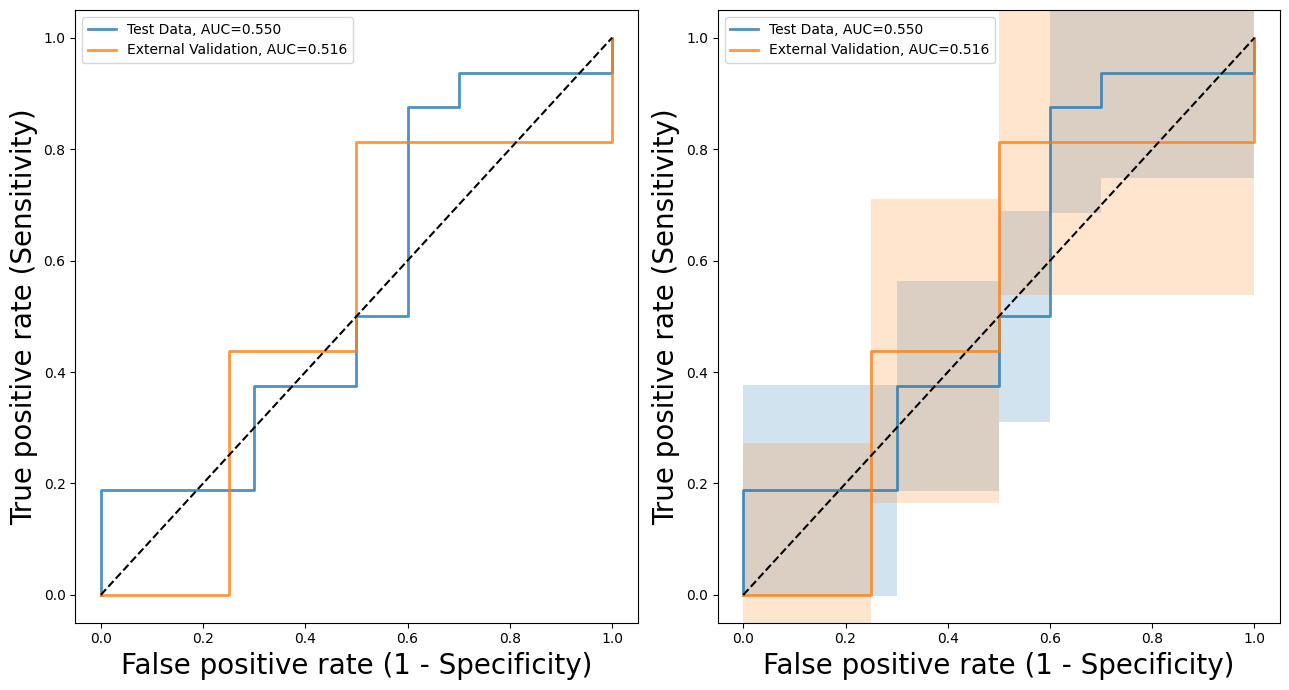

In [61]:
# cv = 9, kl = rbf

# convert values to float
values9 = best_hyperparams_cv9.split(", "); C9 = float(values9[0]); gamma9 = float(values9[1])

# 'MCC'
mcc_Opt_9,thr_Opt_9,y_pred_9,y_test_9,test_probs_9,val_probs_9,cm_50_9,cm_Opt_9,cm_50Val_9,cm_OptVal_9 = model_svm_predict(X_train_sc,y_train,
                                                                    X_test_sc,y_test,
                                                                    X_extVal_sc,y_ExtVal,
                                                                    C9, gamma9,9,
                                                                    K_R_M = 'MCC',kl ="rbf")
print("mcc on training = " + str(mcc_Opt_9))
print("threshold on training = " + str(thr_Opt_9))

# # 'Kappa'
# thr_Opt_9,y_pred_9,y_test_9,test_probs_9,val_probs_9,cm_50_9,cm_Opt_9,cm_50Val_9,cm_OptVal_9 = model_svm_predict(X_train_sc,y_train,
#                                                                     X_test_sc,y_test,
#                                                                     X_extVal_sc,y_ExtVal,
#                                                                     best_hyperparams_cv9,9,
#                                                                     K_R_M = 'Kappa',kl ="rbf")

# confidence intervals for accuracy,recall,precision,specificity
y_pred_opt_9 = []
threshold = thr_Opt_9

y_pred_opt_9 = [1 if x>=threshold else -1 for x in test_probs_9]

savefig('./figs/aucroc_cv9_IM')

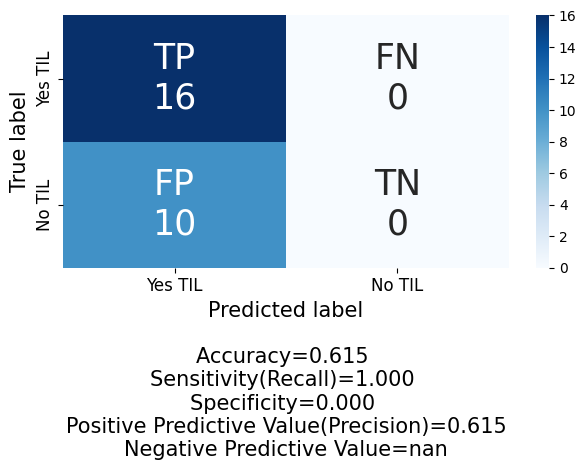

In [62]:
my_cm(cm_50_9)

savefig('./figs/cm_50_9_IM')

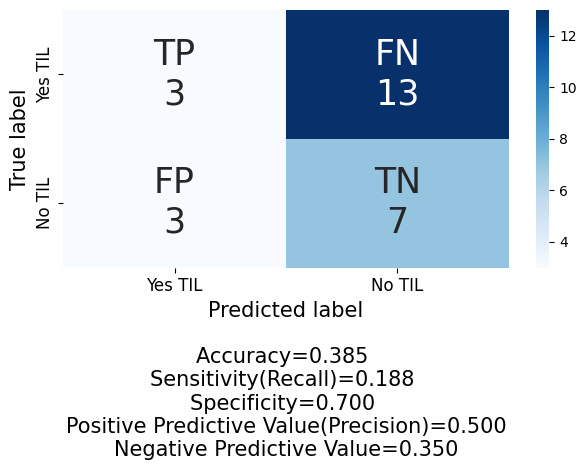

In [63]:
my_cm(cm_Opt_9)

savefig('./figs/cm_Opt_9_IM')

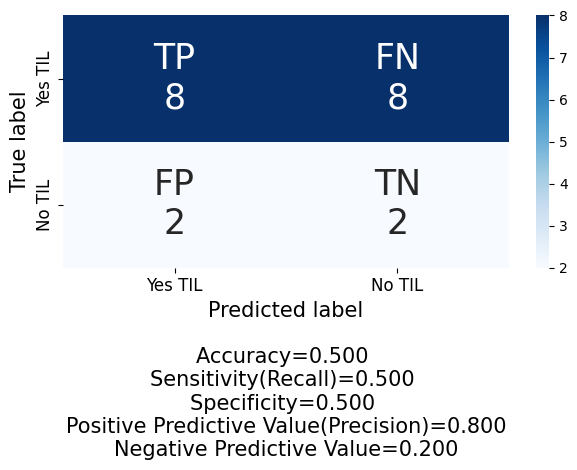

In [64]:
my_cm(cm_OptVal_9)

savefig('./figs/cm_OptVal_9_IM')

thresh: 0.5000, mcc: 0.1581, AUC test-set: 0.5500
[[12  4]
 [ 6  4]]
              precision    recall  f1-score   support

          -1       0.50      0.40      0.44        10
           1       0.67      0.75      0.71        16

    accuracy                           0.62        26
   macro avg       0.58      0.57      0.58        26
weighted avg       0.60      0.62      0.61        26

thresh: 0.5000, mcc: -0.1147, AUC test-set: 0.5312
[[15  1]
 [ 4  0]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.79      0.94      0.86        16

    accuracy                           0.75        20
   macro avg       0.39      0.47      0.43        20
weighted avg       0.63      0.75      0.69        20

thresh: 0.6980, mcc: -0.1299, AUC test-set: 0.5500
[[ 3 13]
 [ 3  7]]
              precision    recall  f1-score   support

          -1       0.35      0.70      0.47        10
           1       0.50     

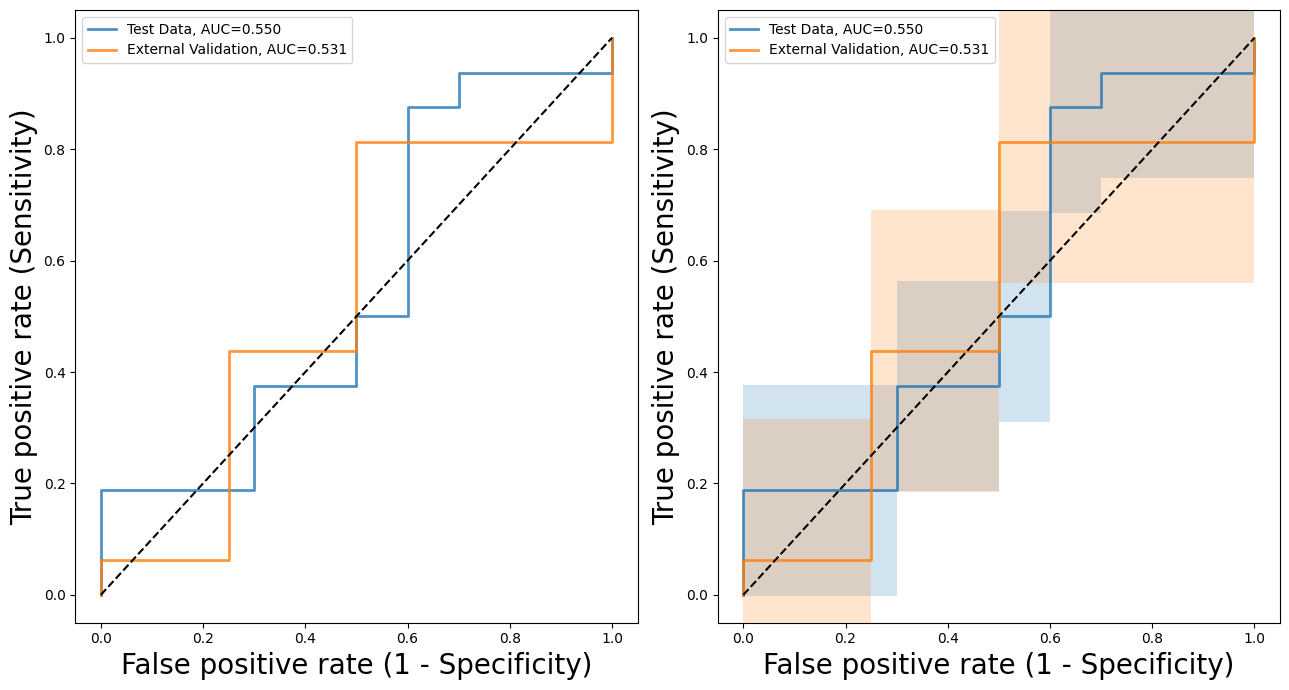

In [65]:
# cv = 10, kl = rbf

# convert values to float
values10 = best_hyperparams_cv10.split(", "); C10 = float(values10[0]); gamma10 = float(values10[1])

# 'MCC'
mcc_Opt_10,thr_Opt_10,y_pred_10,y_test_10,test_probs_10,val_probs_10,cm_50_10,cm_Opt_10,cm_50Val_10,cm_OptVal_10 = model_svm_predict(X_train_sc,y_train,
                                                                         X_test_sc,y_test,
                                                                         X_extVal_sc,y_ExtVal,
                                                                    C10, gamma10,10,
                                                                    K_R_M = 'MCC',kl ="rbf")
print("mcc on training = " + str(mcc_Opt_10))
print("threshold on training = " + str(thr_Opt_10))
# # 'Kappa'
# thr_Opt_10,y_pred_10,y_test_10,test_probs_10,val_probs_10,cm_50_10,cm_Opt_10,cm_50Val_10,cm_OptVal_10 = model_svm_predict(X_train_sc,y_train,
#                                                                          X_test_sc,y_test,
#                                                                          X_extVal_sc,y_ExtVal,
#                                                                     best_hyperparams_cv10,10,
#                                                                     K_R_M = 'Kappa',kl ="rbf")

# confidence intervals for accuracy,recall,precision,specificity
y_pred_opt_10 = []
threshold = thr_Opt_10

y_pred_opt_10 = [1 if x>=threshold else -1 for x in test_probs_10]

savefig('./figs/aucroc_cv10_IM')

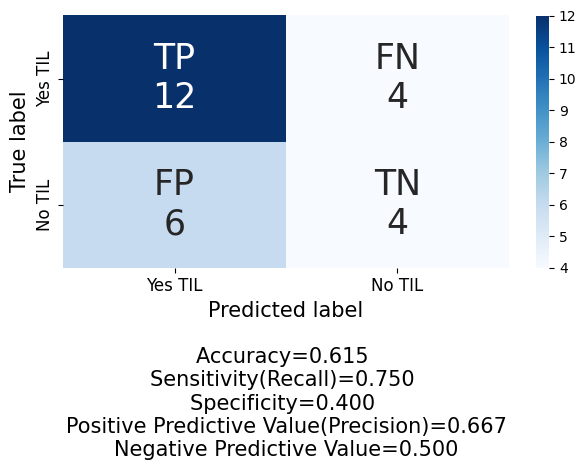

In [66]:
my_cm(cm_50_10)

savefig('./figs/cm_50_10_IM')

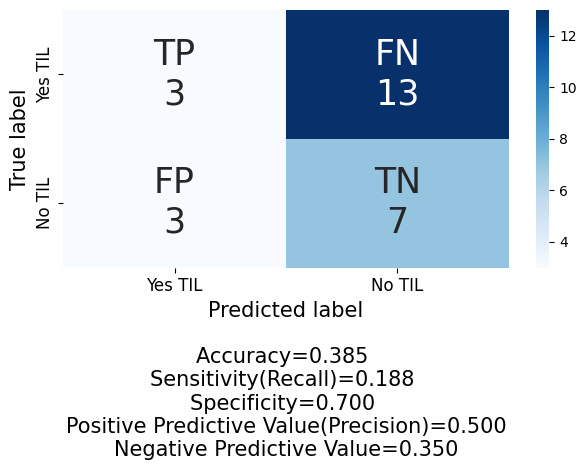

In [67]:
my_cm(cm_Opt_10)

savefig('./figs/cm_Opt_10_IM')

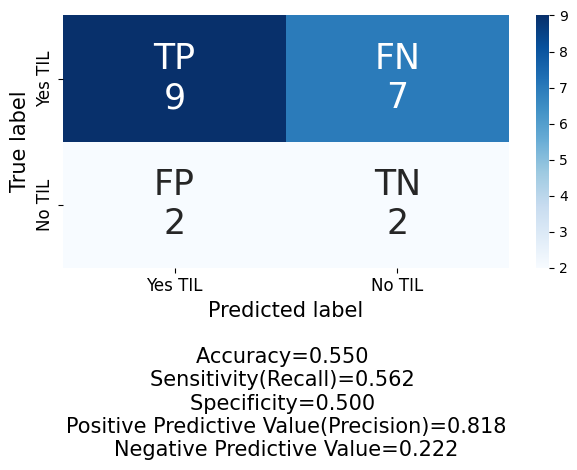

In [68]:
my_cm(cm_OptVal_10)

savefig('./figs/cm_OptVal_10_IM')

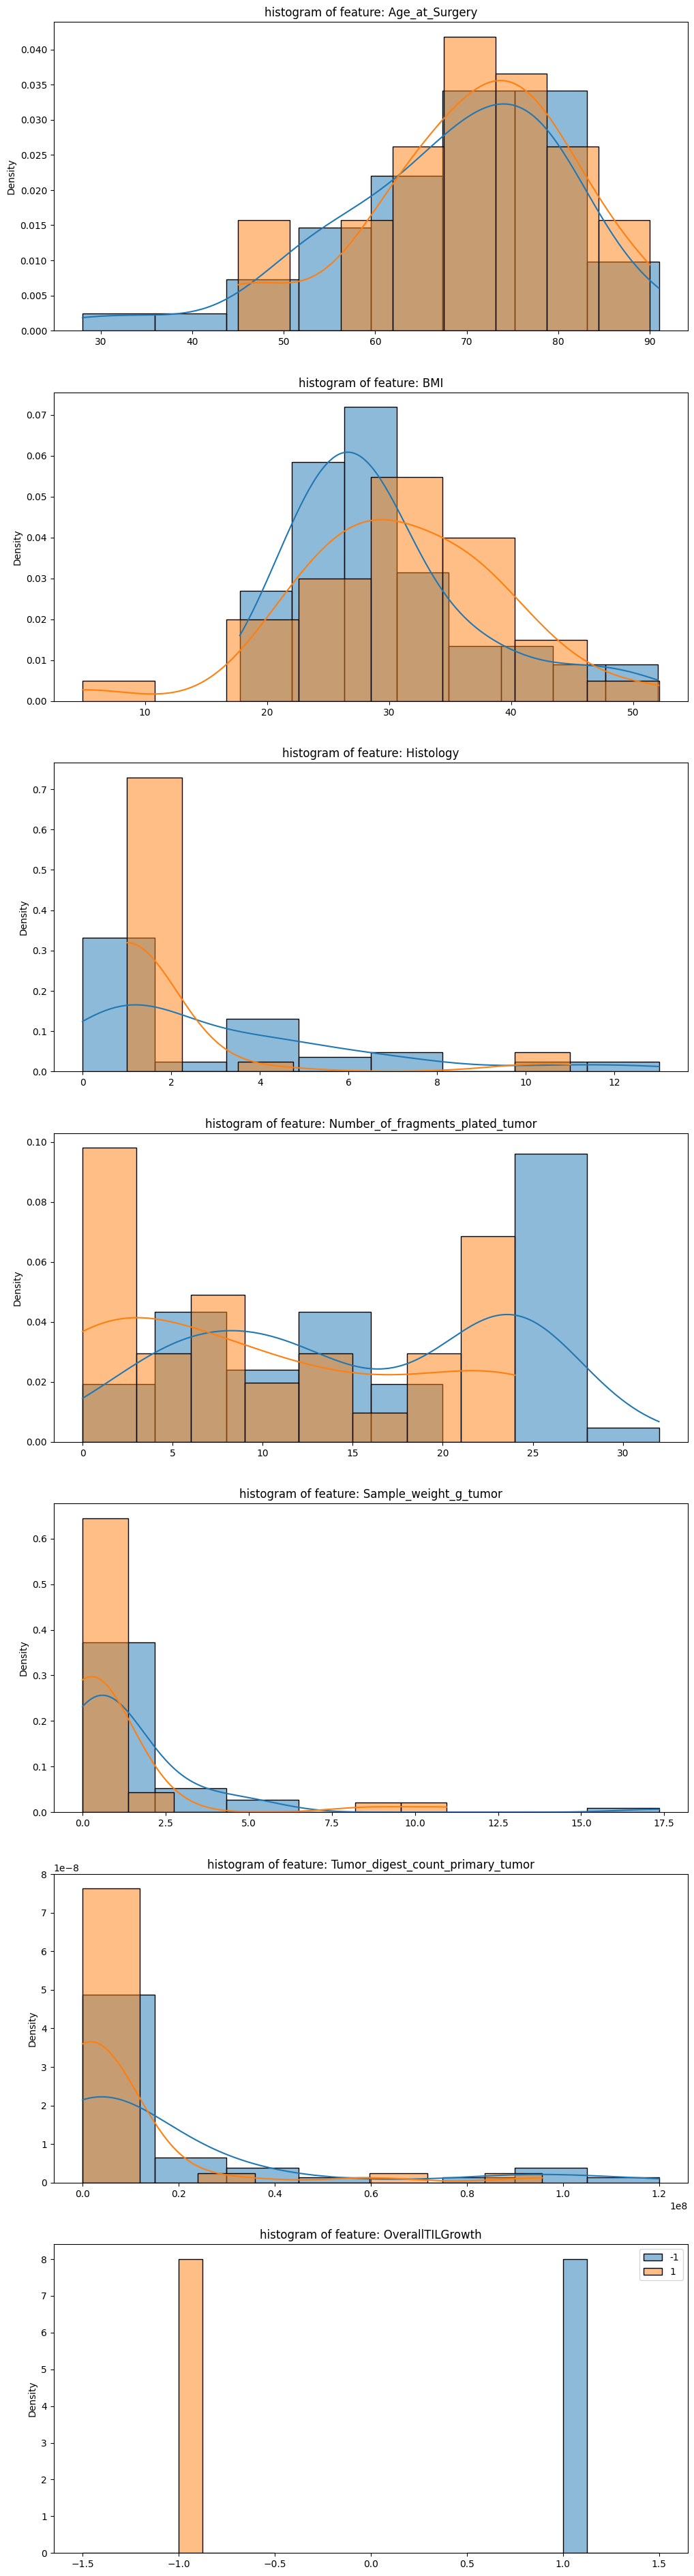

In [69]:
import itertools

import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import rcParams

import os
os.listdir()

diab = Xy_filt

columns=diab.columns[:7]
plt.figure(figsize=(12,35*4))
gs = gridspec.GridSpec(20, 1)
for i, cn in enumerate(diab[columns]):
    ax = plt.subplot(gs[i])
    sns.histplot(diab[cn][diab.OverallTILGrowth == 1], bins=8,stat="density",kde=True)
    sns.histplot(diab[cn][diab.OverallTILGrowth == -1], bins=8,stat="density",kde=True)
    ax.set_xlabel('')
    # plt.legend(diab["OverallTILGrowth"])
    ax.set_title('histogram of feature: ' + str(cn))
plt.legend(diab["OverallTILGrowth"])
plt.show()